In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression



In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

In [3]:
# Make notebook output stable across runs
random_state = 100
np.random.seed(random_state)

REGRESSION

In [52]:
df.head()

,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,CANCELLED,DELAYED_TIME,DELAYED,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,...,MONTH_10,MONTH_11,MONTH_12,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6
0,715,186.0,1065.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1280,235.0,1399.0,0.0,0.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,594,118.0,680.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,969,260.0,1589.0,0.0,24.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1120,181.0,985.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
df = pd.read_csv('../flights_sample_3m_cleaned.csv')

In [6]:
# Cancelled flight show as no delay and no delay time. But they are still a failure
# For our delay time model, we will only attempt non cancelled flight, since
# cancelled flights likely have similar predictors, and so classifying them as 0 delay
# will throw the model off

# Could also be reasonable to set a value for delay time for the cancelled flights,
# however I think there would need to be more expertise to decide what a good value should be there

# Instead, if we try to classify flights, then this model can be used to predict delay times
# for flights that are not classified as cancelled prediction

df_delayed = df[df['CANCELLED'] == 0]

In [7]:
df_delayed.drop('CANCELLED', axis=1, inplace=True)

/var/folders/42/lwn0p9jn7tx0bxw3zzznklvr0000gn/T/ipykernel_10902/1952734233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delayed.drop('CANCELLED', axis=1, inplace=True)


In [21]:
feature_vars = list(df_delayed.columns)

In [22]:
#feature_vars.remove('DELAYED')
feature_vars.remove('DELAYED_TIME')

In [32]:
# Split data into training and test sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(df_delayed[feature_vars], 
                                                 df_delayed['DELAYED_TIME'], 
                                                 test_size=0.2,
                                                 stratify=df_delayed['DELAYED'], 
                                                 random_state=random_state)

In [33]:
# Drop the delayed column now that we are stratified
X_train = X_train.drop('DELAYED', axis=1)
X_test = X_test.drop('DELAYED', axis=1)

In [35]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
# Model for predicting delay duration - Regression
model_delay = LinearRegression()
model_delay.fit(X_train, y_train)

LinearRegression()

In [37]:
predictions_delay = model_delay.predict(X_test)
print("Mean Squared Error for Delay Duration Prediction:", mean_squared_error(y_test, predictions_delay))

Mean Squared Error for Delay Duration Prediction: 2052.0337679599593


In [42]:
predictions_delay.shape

(422174,)

In [39]:
predictions_delay

array([ 6.74930479, 19.72196104, 11.10086729, ..., 16.33621886,
       15.28153136, 11.96121886])

In [41]:
np.count_nonzero(predictions_delay > 0)

416703

In [44]:
# Get % of original that was delayed
df_delayed[df_delayed['DELAYED'] == 1].shape[0] / df_delayed.shape[0]

0.18681017779399015

In [50]:
np.count_nonzero(predictions_delay > 18)

76860

In [51]:
76860 / 422174

0.18205763500357672

So in practical use, we may use 18 as a threshold before displaying a flight might be delayed, and show flights with under 18 predicted delay time as normal.

Through testing with beta users, could tweak and see what people enjoy more; lowering the threshold 

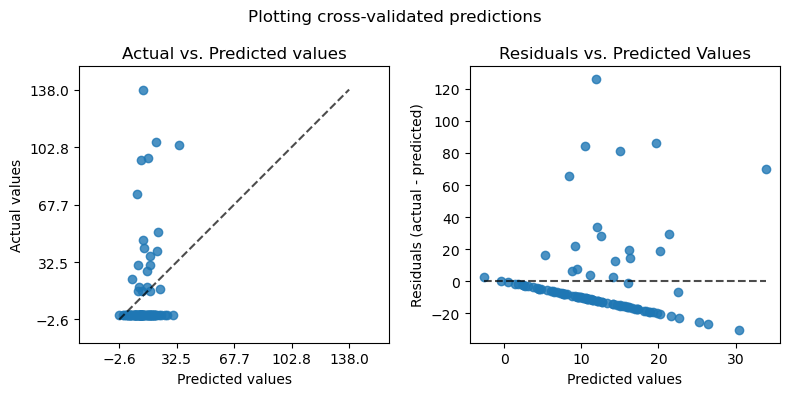

In [56]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=predictions_delay,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=predictions_delay,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

In [57]:
# Create dataframe with predictions delay and y test
df_delayed_test = df_delayed.loc[y_test.index]
df_delayed_test['DELAYED_PRED'] = predictions_delay
df_delayed_test.head()

,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,DELAYED_TIME,DELAYED,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,...,MONTH_11,MONTH_12,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DELAYED_PRED
1947749,665,90.0,417.0,0.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,6.749305
1824884,1345,105.0,580.0,68.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,19.721961
1823280,734,103.0,507.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,11.100867
554871,640,158.0,860.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4.452430
473879,1402,315.0,2429.0,0.0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,30.663367


In [65]:
df_delayed_test[(df_delayed_test['DELAYED_PRED'] > 18) & (df_delayed_test['DELAYED'] == 1)].shape[0]

23914

In [66]:
df_delayed_test[(df_delayed_test['DELAYED_PRED'] < 18) & (df_delayed_test['DELAYED'] == 1)].shape[0]

54952

In [67]:
df_delayed_test[(df_delayed_test['DELAYED_PRED'] > 18) & (df_delayed_test['DELAYED'] == 0)].shape[0]

52946

In [85]:
23914 / (23914 + 52946)

0.31113713244860786

In [68]:
df_delayed_test[(df_delayed_test['DELAYED_PRED'] < 18) & (df_delayed_test['DELAYED'] == 0)].shape[0]

290362

In [63]:
# Percentage delayed that were predicted over 18 minutes delayed
df_delayed_test[(df_delayed_test['DELAYED_PRED'] > 18) & (df_delayed_test['DELAYED'] == 1)].shape[0] / df_delayed_test[df_delayed_test['DELAYED'] == 1].shape[0]


0.30322318869981996

In [86]:
df_delayed_test[(df_delayed_test['DELAYED_PRED'] > 18) & (df_delayed_test['DELAYED'] == 1)].shape[0] / df_delayed_test[df_delayed_test['DELAYED_PRED'] > 18].shape[0]

0.31113713244860786

In [64]:
# So the percent that were predicted under 18 but were delayed
df_delayed_test[(df_delayed_test['DELAYED_PRED'] < 18) & (df_delayed_test['DELAYED'] == 1)].shape[0] / df_delayed_test[df_delayed_test['DELAYED'] == 1].shape[0]

0.6967768113001801

In [70]:
# Predicted over 18 but not delayed
df_delayed_test[(df_delayed_test['DELAYED_PRED'] > 18) & (df_delayed_test['DELAYED'] == 0)].shape[0] / df_delayed_test[df_delayed_test['DELAYED'] == 1].shape[0]

0.6713412623944413

In [84]:
df_delayed_test[(df_delayed_test['DELAYED_PRED'] > 18) & (df_delayed_test['DELAYED'] == 1)].shape[0] / (df_delayed_test[(df_delayed_test['DELAYED'] == 1) & (df_delayed_test['DELAYED_PRED'] > 18)].shape[0] + df_delayed_test[(df_delayed_test['DELAYED'] == 0) & (df_delayed_test['DELAYED_TIME'] < 18)].shape[0])

0.053608256666846

So using this method and setting a threshold before classifying a flight as "likely delayed" for the users when predicted time is over 18 would be very inaccurate.

In [72]:
# Predicted under 18 and not delayed
df_delayed_test[(df_delayed_test['DELAYED_PRED'] < 18) & (df_delayed_test['DELAYED'] == 0)].shape[0] / df_delayed_test[df_delayed_test['DELAYED'] == 0].shape[0]

0.8457769699511809

In [77]:
# Set predicted delay to 1 if DELAYED_PRED time is > 18
df_delayed_test['DELAYED_PRED_YN'] = df_delayed_test['DELAYED_PRED'].apply(lambda x: 1 if x > 18 else 0)

In [78]:
accuracy_score(df_delayed_test['DELAYED'], df_delayed_test['DELAYED_PRED_YN'])

0.7444229156698423

In [79]:
df_actual_delay = df_delayed_test[df_delayed_test['DELAYED'] == 1]

In [74]:
df_actual_delay.head()

,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,DELAYED_TIME,DELAYED,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,...,MONTH_11,MONTH_12,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DELAYED_PRED
1824884,1345,105.0,580.0,68.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,19.721961
1907690,949,219.0,1524.0,163.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,18.499305
943681,1199,141.0,569.0,61.0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,21.366492
1611198,842,158.0,854.0,42.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,15.139930
1870306,1019,211.0,1372.0,34.0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,31.206336


In [88]:
# Split data into training and test sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(df_actual_delay[feature_vars], 
                                                 df_actual_delay['DELAYED_TIME'], 
                                                 test_size=0.2,
                                                 random_state=random_state)

In [89]:
# Drop the delayed column now that we are stratified
X_train = X_train.drop('DELAYED', axis=1)
X_test = X_test.drop('DELAYED', axis=1)

In [90]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [91]:
# Model for predicting delay duration - Regression
model_delay = LinearRegression()
model_delay.fit(X_train, y_train)

LinearRegression()

In [92]:
predictions_delay = model_delay.predict(X_test)
print("Mean Squared Error for Delay Duration Prediction:", mean_squared_error(y_test, predictions_delay))

Mean Squared Error for Delay Duration Prediction: 8155.372631956798


In [96]:
predictions_delay

array([45.96523685, 54.65273685, 68.09023685, ..., 87.32461185,
       77.62148685, 49.99648685])

In [97]:
# Create dataframe with predictions delay and y test
df_actual_delay = df_actual_delay.loc[y_test.index]
df_actual_delay['DELAYED_PRED2'] = predictions_delay
df_actual_delay.head()

,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,DELAYED_TIME,DELAYED,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,...,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DELAYED_PRED,DELAYED_PRED_YN,DELAYED_PRED2
1455412,540,130.0,849.0,36.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,6.589149,0,45.965237
2023510,925,160.0,919.0,92.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,14.132117,0,54.652737
1045879,972,238.0,1506.0,38.0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,12.507117,0,68.090237
978502,1270,105.0,516.0,167.0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,15.495399,0,53.246487
1281037,1135,220.0,1587.0,76.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,12.733680,0,51.035549


In [98]:
df_actual_delay['DELAYED_TIME']

1455412     36.0
2023510     92.0
1045879     38.0
978502     167.0
1281037     76.0
           ...  
1994849     36.0
495548      64.0
2093059     17.0
1878488     46.0
618369      23.0
Name: DELAYED_TIME, Length: 15774, dtype: float64

In [99]:
print("Mean Squared Error for Delay Duration Prediction on Flights Delayed:", mean_squared_error(df_actual_delay['DELAYED_TIME'], df_actual_delay['DELAYED_PRED2']))

Mean Squared Error for Delay Duration Prediction on Flights Delayed: 8155.372631956798


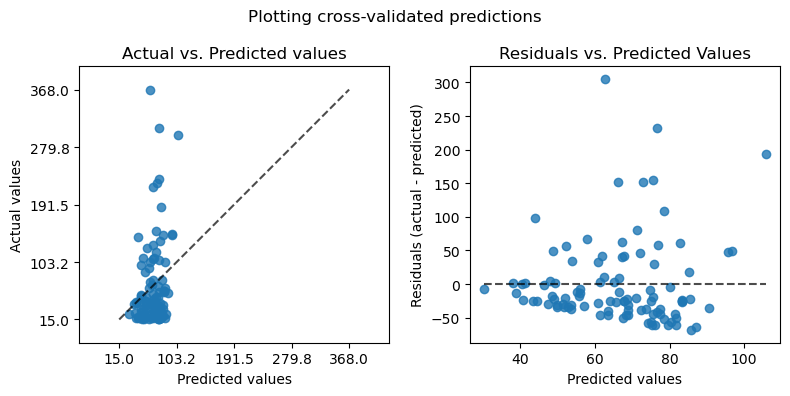

In [100]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    df_actual_delay['DELAYED_TIME'],
    y_pred=df_actual_delay['DELAYED_PRED2'],
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    df_actual_delay['DELAYED_TIME'],
    y_pred=df_actual_delay['DELAYED_PRED2'],
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

So model did not do great predicting time on those actually delayed